In [ ]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import torch
import scipy.sparse as sp

from rich import print
import warnings
warnings.filterwarnings("ignore")
import os

outdir = "/Users/jessica/Desktop/GitHub/Jessica_notebooks/write/02_cd4_batch_annotation/PICA0001-PICA0007"
os.makedirs(outdir, exist_ok=True)
sc.settings.figdir = "/Users/jessica/Desktop/GitHub/Jessica_notebooks/figures/PICA0001-PICA0007/02_annotation_cd4"


In [ ]:
# Visualize the current cd4 annotation progress
cd4 = sc.read_h5ad("/Users/jessica/Desktop/GitHub/Jessica_notebooks/write/02_batch_annotation//PICA0001-PICA0007/PICA0001-PICA0007_cd4_annotations.h5ad")
print(cd4)

AnnData object with n_obs × n_vars = 9903 × 38606
    obs: 'status', 'assignment', 'pica_id', 'pool_id', 'sequencing_batch', 'n_genes_by_counts', 
'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 
'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 
'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 
'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'status_manual', 'cell_type', 
'status_manual_01_b_subset', 'broad_cell_type', 'cell_type_01_b_cell', 'cell_type_01_b_cell_corrected', 
'cell_type_02_t_cell_broad', 'cell_type_03_t_cell_subtype', 'cell_type_04_myeloid_subset', '_scvi_batch', 
'_scvi_labels', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_1.5', 'leiden_res_2.0', 'cell_type_cd4_res_1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 
'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 
'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 
'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 
'log1p_total_counts-2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 
'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_cd4_res_1_colors', 'cell_type_colors', 'hvg', 
'leiden_res_0.5', 'leiden_res_0.5_colors', 'leiden_res_1.0', 'leiden_res_1.0_colors', 'leiden_res_1.5', 
'leiden_res_1.5_colors', 'leiden_res_2.0', 'leiden_res_2.0_colors', 'log1p', 'neighbors', 'pca', 'pica_id_colors', 
'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [65]:
cd4.obs['cell_type_cd4_res_1'].unique()
cd4.obs['cell_type_cd4_res_1'].value_counts()

cell_type_cd4_res_1
Naive/Central memory CD4 T cell    9372
Regulatory T cell                   267
CCR6+ memory CD4 T cell             221
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

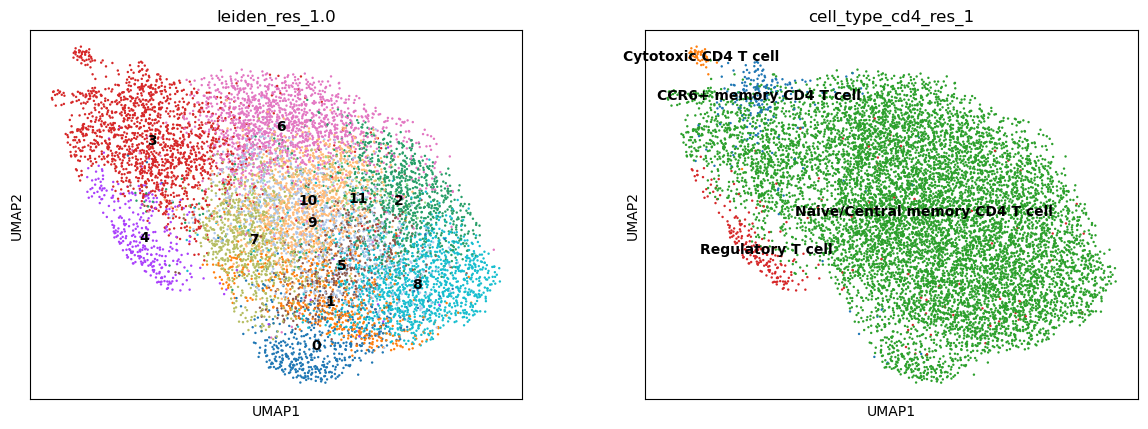

In [66]:
sc.pl.umap(cd4, color=['leiden_res_1.0', 'cell_type_cd4_res_1'], legend_loc='on data', legend_fontsize= 10)

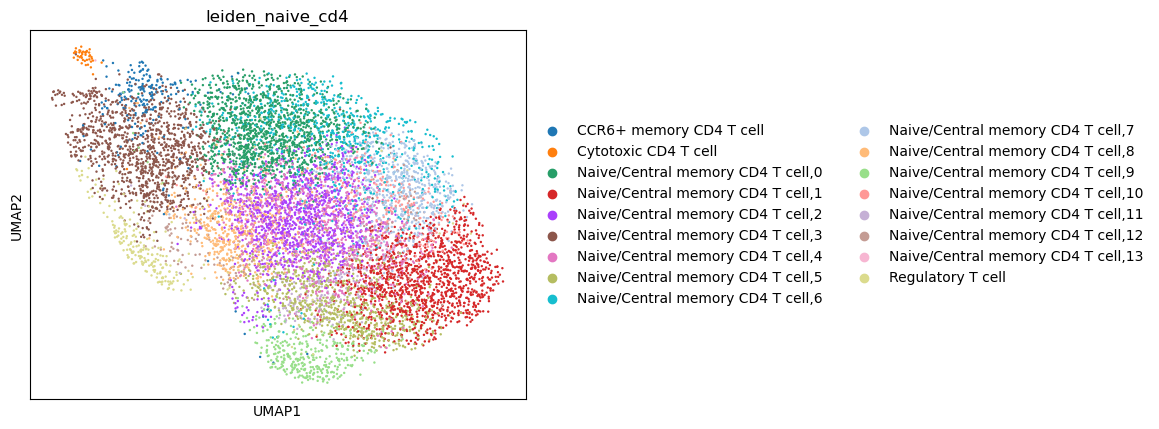

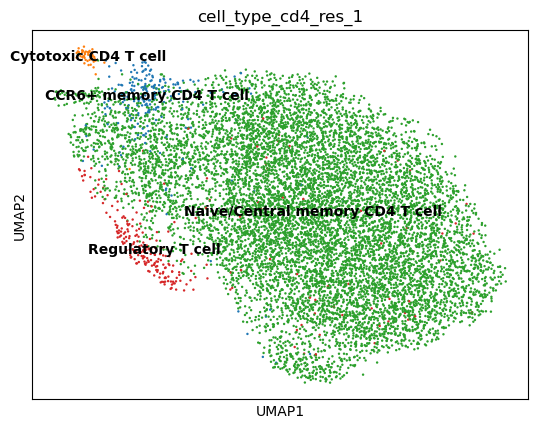

In [67]:
naive_memory_cd4 = cd4.copy()
sc.tl.leiden(naive_memory_cd4, resolution=1.0, restrict_to=('cell_type_cd4_res_1', ['Naive/Central memory CD4 T cell']), key_added='leiden_naive_cd4')
sc.pl.umap(naive_memory_cd4, color=['leiden_naive_cd4'], legend_loc='right margin')
sc.pl.umap(naive_memory_cd4, color=['cell_type_cd4_res_1'], legend_loc='on data')

In [68]:
cd4_markers = {
    # Identity
    "CD4 T cell": ["CD4", "CD3D", "CD3E"],

    # Core
    "Naive CD4 T cell": ["CCR7", "TCF7", "LEF1", "FOXP1", "PTPRC", "STAT6"],
    "Activated CD4 T cell": ['CCR7', 'CD40LG', 'CD69', 'ICOS', 'SELL', 'SOCS3', 'STAT3', 'TCF7', 'IL2RA', 'CD44', 'HLA-DRB1'],
    "CD4 central memory T cell": ["CCR7", "CD27", "CD28", "SELL", 'CD44', "TCF7", "IL7R", "BCL2", "PTPRC"],
    "CD4 effector memory T cell": ['CCR7', "IL7R", "AQP3", "CCR6", 'KLRB1', "DPP4",  "IFNG", "TNF", "IL2"], # CCR7-
    "T Stem cell Memory (Tscm)": ["PTPRC", "CCR7", "FAS", "IL7R", "SELL", "BCL2", "LEF1"],

    # cytotoxic and regulatory
    "Cytotoxic CD4 T cell": ["CD27", "CD28", "GZMB", "PRF1", "NKG7", "CCL3", "CCL4", "CCL5", "IFNG", "TBX21"], # CD27- CD28-
    "Regulatory T cell (Treg)": ["FOXP3", "IL2RA", "CTLA4", "TNFRSF18", "IKZF2", "ENTPD1"],

    # TFH / Tfr
    "TFH": ["CXCR5","PDCD1","ICOS","BCL6","MAF","BATF","SH2D1A","SLAMF6","TOX2","IL21"],
    "pre-TFH/activated": ["PDCD1","ICOS","CXCR5"],  # with CCR7/IL7R not clearly down
    "Tph (exclude)": ["PDCD1","ICOS","CXCL13","MAF","IL21","CCR2"],  # CXCR5−
    "Tfr": ["FOXP3","IL2RA","CTLA4","CXCR5","PDCD1","BCL6","IKZF2","TIGIT"],

    # Th polarizations
    "Th1": ["TBX21","IFNG","CXCR3","STAT1"],
    "Th2": ["GATA3","IL4","IL5","IL13","CCR4","STAT6"],
    "Th17": ["RORC","IL17A","IL17F","IL22","CCR6","STAT3"],

    # Veto (for QC only)
    "Bcell_veto": ["MS4A1","CD79A","CD79B","CD19","CD74","IGHM","IGKC"],
    "NKCD8_veto": ["CD8A","CD8B","NKG7","GNLY","PRF1","GZMB","KLRD1","NCR1","FCGR3A"],
    "Myeloid_veto": ["LYZ","LST1","S100A8","S100A9","ITGAX","FCGR3A"],
}


“veto” markers added so PD-1–high activated CD4s or Tph don’t get miscalled as TFH, If any of these light up with your TFH set,might be doublets/contamination.

Distinguish close look-alikes:

Activated/pre-TFH CD4: PDCD1↑, ICOS↑, but CXCR5 low/−, BCL6 low/−, CCR7/IL7R not clearly down.

Tph (peripheral helper) (avoid mislabel): PDCD1^hi, ICOS↑, CXCR5−, CXCL13↑, MAF↑, IL21↑, often CCR2↑.

Cytotoxic-leaning CD4: NKG7/GZMB/PRF1/GNLY↑ (not TFH).

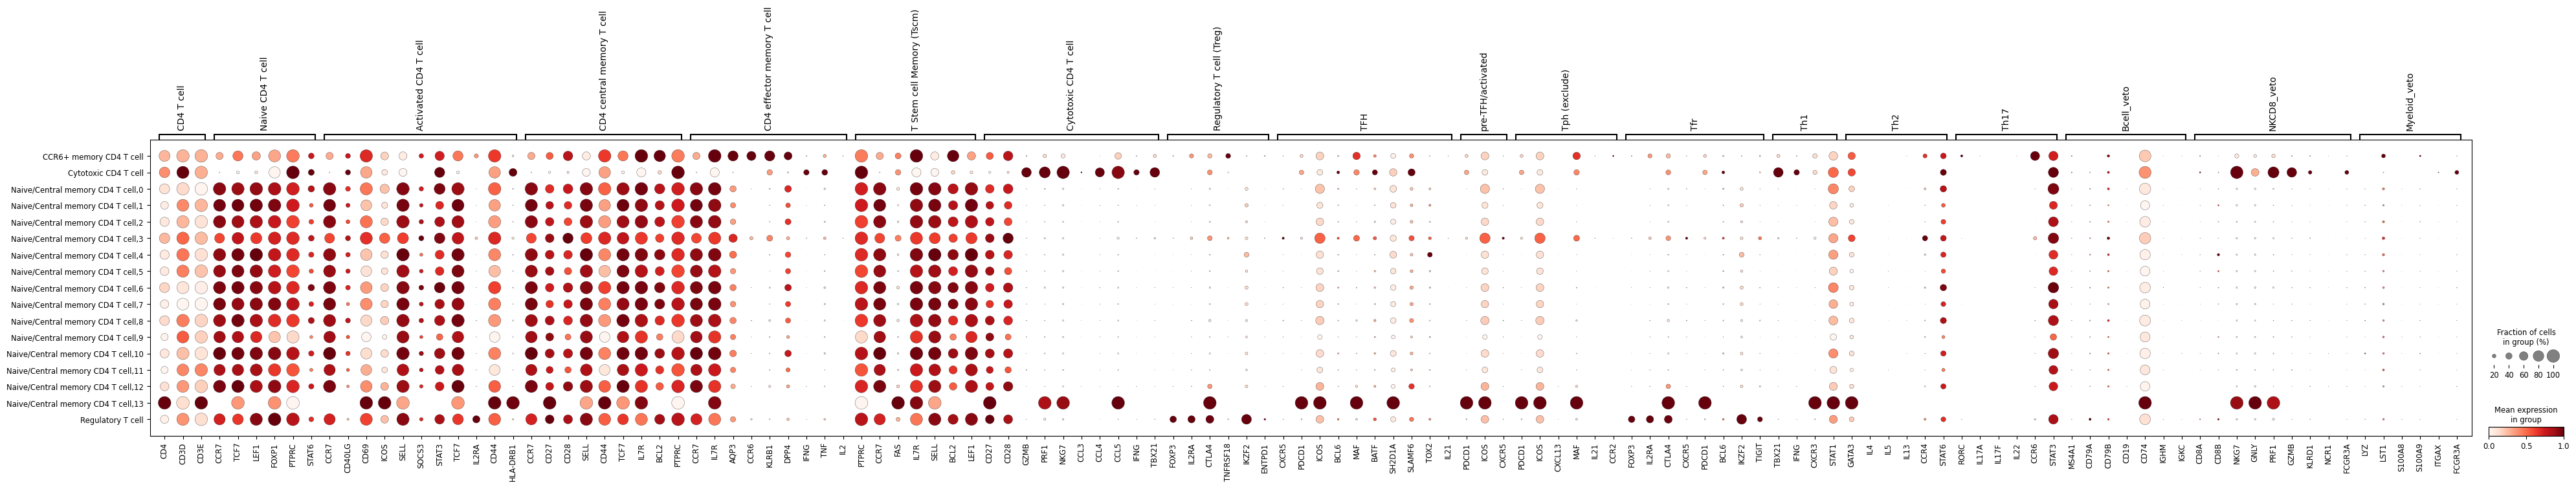

In [69]:
sc.pl.dotplot(naive_memory_cd4, cd4_markers, groupby="leiden_naive_cd4", standard_scale="var")


TFH: CXCR5↑, CCR7↓, IL7R↓, maybe CXCL13↑
Activated/pre-TFH: PDCD1/ICOS↑ but CXCR5 weak or −, CCR7/IL7R still moderate

cluster 3 co expresses CXCR5, PDCD1 and ICOS = tfh
cluster 13 is not tfh as it has b cell markers --> might be doublets


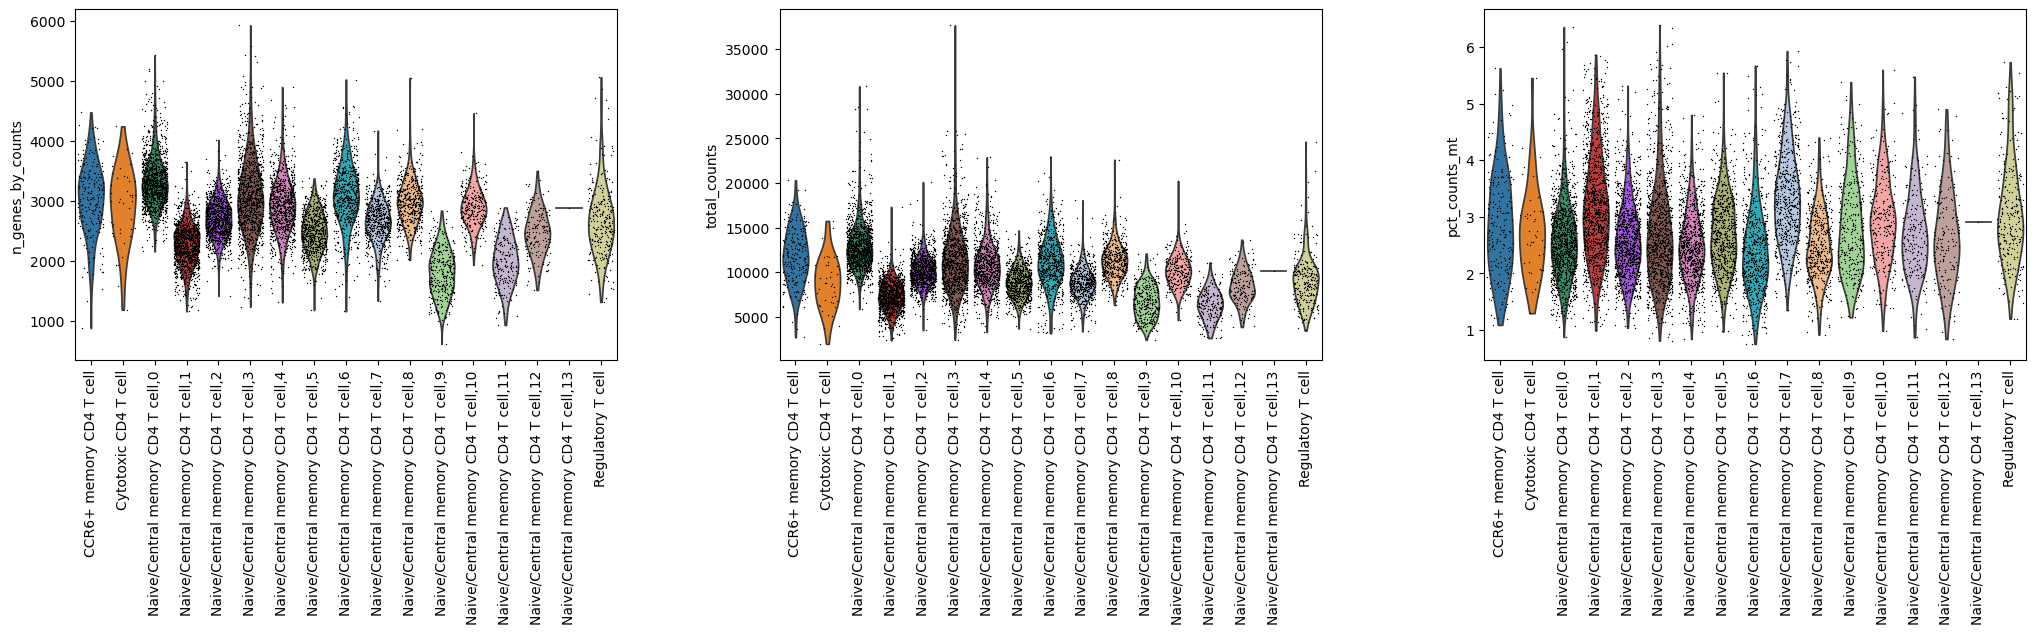

In [70]:

sc.pl.violin(naive_memory_cd4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby= 'leiden_naive_cd4', jitter=0.4, multi_panel=True, rotation=90)


In [71]:
naive_memory_cd4.obs['leiden_naive_cd4'].value_counts()


leiden_naive_cd4
Naive/Central memory CD4 T cell,0     1290
Naive/Central memory CD4 T cell,1     1258
Naive/Central memory CD4 T cell,2     1146
Naive/Central memory CD4 T cell,3     1128
Naive/Central memory CD4 T cell,4      954
Naive/Central memory CD4 T cell,5      781
Naive/Central memory CD4 T cell,6      687
Naive/Central memory CD4 T cell,7      592
Naive/Central memory CD4 T cell,8      514
Naive/Central memory CD4 T cell,9      357
Naive/Central memory CD4 T cell,10     286
Regulatory T cell                      267
CCR6+ memory CD4 T cell                221
Naive/Central memory CD4 T cell,11     208
Naive/Central memory CD4 T cell,12     170
Cytotoxic CD4 T cell                    43
Naive/Central memory CD4 T cell,13       1
Name: count, dtype: int64

### Note that Cluster 13 is low quality cells

### Annotate tfh cluster

In [72]:

naive_memory_cd4.obs['cell_type'] = naive_memory_cd4.obs['cell_type'].astype(str)
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,0', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,1', 'cell_type'] = 'Naive/Central memory CD4 T cell'  
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,2', 'cell_type'] = 'Naive/Central memory CD4 T cell'
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,3', 'cell_type'] = 'Tfh / cTfh' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,4', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,5', 'cell_type'] = 'Naive/Central memory CD4 T cell'
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,6', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,7', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,8', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,9', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,10', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,11', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,12', 'cell_type'] = 'Naive/Central memory CD4 T cell' 
naive_memory_cd4.obs.loc[naive_memory_cd4.obs['leiden_naive_cd4'] == 'Naive/Central memory CD4 T cell,13', 'cell_type'] = 'Naive/Central memory CD4 T cell' 

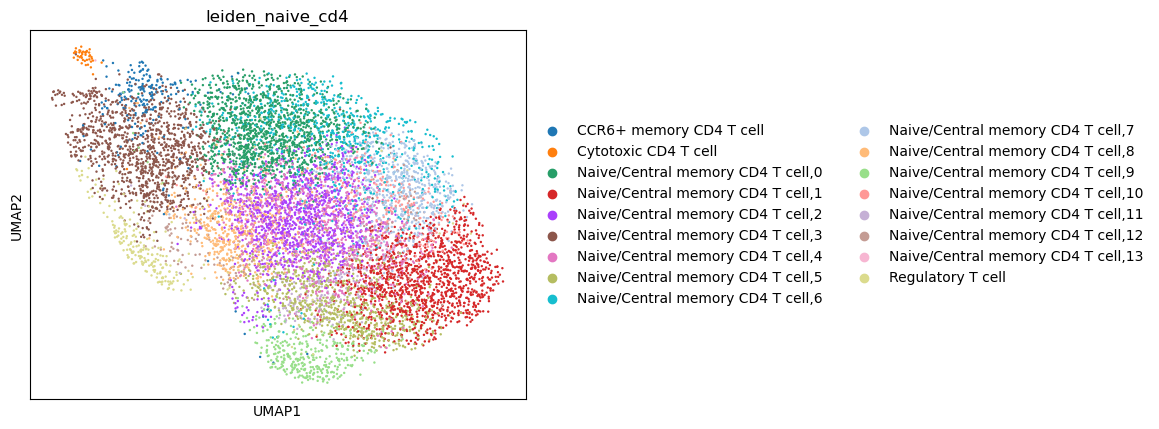

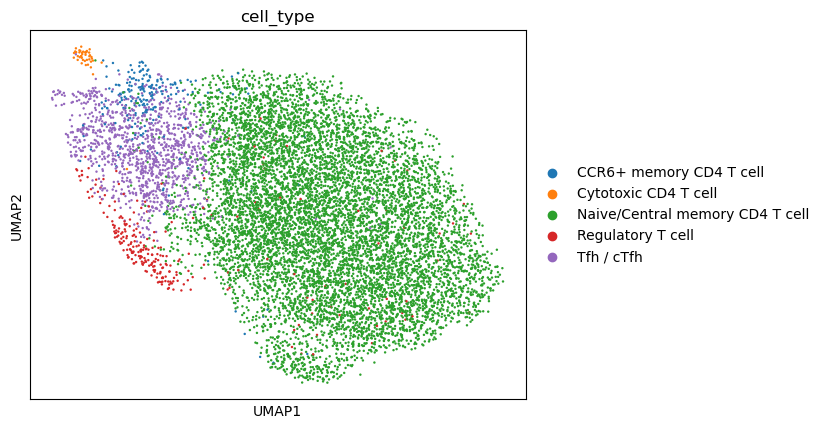

In [73]:
sc.pl.umap(naive_memory_cd4, color=['leiden_naive_cd4'], legend_loc='right margin')
sc.pl.umap(naive_memory_cd4, color=[ 'cell_type'], legend_loc='right margin')


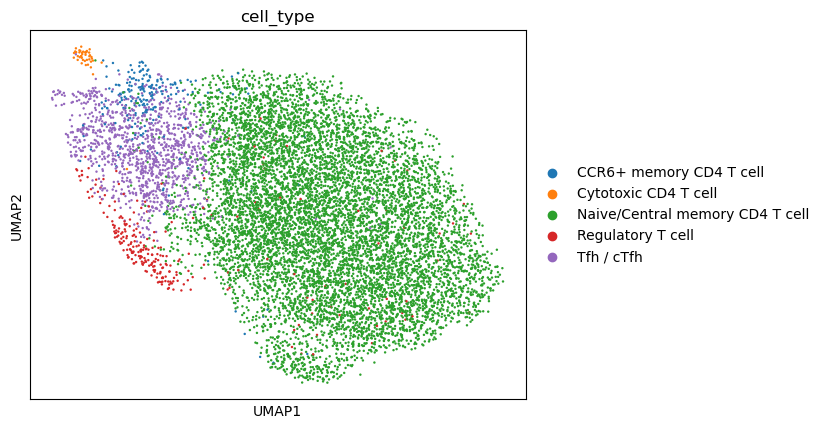

In [74]:
# Update the cell annotation
cd4.obs['cell_type'] = cd4.obs['cell_type'].astype(str)
cd4.obs['cell_type'].update(naive_memory_cd4.obs['cell_type'])
sc.pl.umap(cd4, color='cell_type')

In [75]:
cd4.obs['cell_type'].unique()
cd4.obs['cell_type'].value_counts()

cell_type
Naive/Central memory CD4 T cell    8244
Tfh / cTfh                         1128
Regulatory T cell                   267
CCR6+ memory CD4 T cell             221
Cytotoxic CD4 T cell                 43
Name: count, dtype: int64

In [ ]:
cd4.write_h5ad("/Users/jessica/Desktop/GitHub/Jessica_notebooks/write/02_cd4_batch_annotation/PICA0001-PICA0007/PICA0001-PICA0007_cd4_scVI_annot_tfh.h5ad", compression='gzip')
